In [1]:
!pip3 install gensim
!pip3 install pyLDAvis
!pip3 install numpy
!pip3 install wordcloud

import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.utils import SaveLoad
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from re import sub
import pyLDAvis
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import seaborn as sns
import pyLDAvis.gensim_models
import numpy as np
import nltk
nltk.download('stopwords')

/home/ermi/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ermi/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
[nltk_data] Downloading package stopwords to /home/ermi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv('../cleaned_tweet_data.csv')

In [6]:
df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,188.0,43.0,davideiacovozzi,18,18,NaN,"[{'text': 'gold', 'indices': [116, 121]}, {'te...","[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,NaN,0.175000,en,NaN,NaN,davideiacovozzi,18,18,NaN,[],"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,193.0,26.0,davideiacovozzi,18,18,False,[],"[{'screen_name': 'goldseek', 'name': 'Peter ⚒ ...",NaN
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,620.0,213.0,davideiacovozzi,18,18,NaN,[],"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,1787.0,417.0,davideiacovozzi,18,18,False,[],"[{'screen_name': 'biancoresearch', 'name': 'Ji...",NaN


In [7]:
df.shape

(16367, 15)

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['original_text'][0]

# convert all original_text fields to strings
df['original_text'] = df['original_text'].astype(str)
df['clean_text'] = df['original_text'].str.replace('[^\w\s]','')
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# re.sub('\w*\d\w*', '', text)
df['clean_text'] = df['clean_text'].str.replace('\w*\d\w*','')
# df.head()


# normally we tokenize using words so each word as a token
#Lines 4 to 6
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

df[['polarity','original_text','clean_text']].head()

print('hey')

<>:8: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \w
/tmp/ipykernel_60504/620628855.py:8: DeprecationWarning: invalid escape sequence \w
  df['clean_text'] = df['original_text'].str.replace('[^\w\s]','')
/tmp/ipykernel_60504/620628855.py:12: DeprecationWarning: invalid escape sequence \w
  df['clean_text'] = df['clean_text'].str.replace('\w*\d\w*','')
/tmp/ipykernel_60504/620628855.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['original_text'].str.replace('[^\w\s]','')
/tmp/ipykernel_60504/620628855.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['clean_text'].str.replace('\w*\d\w*','')


hey


In [9]:
df['original_text'][0]

"RT @NorthstarCharts: The 10-year yield is telling us that there's a high risk of something 'breaking' in the system #gold #silver #crypto #…"

In [10]:
df['clean_text'][0]

'rt northstarchart the yield tell us there high risk someth break system gold silver crypto'

In [13]:
df.to_pickle('cleaned_tweet.pkl')

In [17]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/ermi/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /home/ermi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
#Data cleaning
wnl = WordNetLemmatizer()

def removePunc(myWord):
    """Function to remove punctuation from string inputs"""
    if myWord is None:
        return myWord
    else:
        return sub('[.:;()/!&-*@$,?^\d+]','',myWord)
        
def removeAscii(myWord):
    """Function to remove ascii from string input"""
    if myWord is None:
        return myWord
    else:
        return str(sub(r'[^\x00-\x7F]+','', myWord.strip()))

def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return str(wnl.lemmatize(myWord))

def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopwords.words('english')):
        return myWord

def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('@') and not myWord.startswith('http'):
        return myWord

def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(
            removeAscii(
                removePunc(
                    removeLinkUser(
                        myWord.lower()
                    )
                )
            )
        )
    )

<>:9: DeprecationWarning: invalid escape sequence \d
<>:9: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_25386/2831030072.py:9: DeprecationWarning: invalid escape sequence \d
  return sub('[.:;()/!&-*@$,?^\d+]','',myWord)


In [20]:
#Filtering Words
def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]

In [21]:
cleanKagTweetList = filterTweetList(df['clean_text'])

In [22]:
cleanKagTweetList[:5]

[['northstarchart',
  'yield',
  'tell',
  'high',
  'risk',
  'someth',
  'break',
  'system',
  'gold',
  'silver',
  'crypto'],
 ['michaelaarouet',
  'german',
  'mortgag',
  'rate',
  'went',
  'hear',
  'sound',
  'german',
  'real',
  'estat',
  'bubbl',
  'burst'],
 ['goldseek'],
 ['charliebilello',
  'mortgag',
  'rate',
  'rise',
  'highest',
  'level',
  'sinc',
  'last',
  'year',
  'hit',
  'alltim'],
 ['biancoresearch',
  'rate',
  'rise',
  'someth',
  'break',
  'anyth',
  'broken',
  'yet']]

In [23]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

In [24]:
"""Create model objects"""
kagDict   = makeDict(cleanKagTweetList)
kagCorpus = makeCorpus(cleanKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

"""Save model objects"""
SaveLoad.save(kagLda,'kaggleLDAmodel')
corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
kagDict.save('kaggleDictionary.dict')

In [28]:
kagLda = SaveLoad.load('kaggleLDAmodel')
kagDict = corpora.Dictionary.load('kaggleDictionary.dict')
kagCorpus = corpora.MmCorpus('kaggleCorpus.mm')

In [25]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim_models.prepare(kagLda, kagCorpus, kagDict)

/home/ermi/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/ermi/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ermi/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ermi/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ermi/anaconda3/lib/python3.9/site-packages/past/builtins/mis

In [30]:
kagLda.print_topics()

[(5,
  '0.031*"pm" + 0.025*"tomorrow" + 0.023*"wordl" + 0.017*"borisjohnson" + 0.017*"india" + 0.011*"narendramodi" + 0.011*"effort" + 0.011*"one" + 0.010*"make" + 0.010*"problem"'),
 (45,
  '0.015*"lol" + 0.012*"amp" + 0.010*"woman" + 0.008*"men" + 0.007*"democraci" + 0.007*"near" + 0.007*"call" + 0.007*"funni" + 0.007*"isra" + 0.007*"democrat"'),
 (14,
  '0.074*"price" + 0.029*"inflat" + 0.022*"chang" + 0.017*"oil" + 0.016*"increas" + 0.015*"gold" + 0.015*"fuel" + 0.015*"hike" + 0.015*"high" + 0.012*"valu"'),
 (27,
  '0.057*"srilanka" + 0.041*"protest" + 0.039*"lka" + 0.032*"cartoon" + 0.027*"economiccrisislk" + 0.022*"srilankacrisi" + 0.018*"tamil" + 0.016*"srilankaprotest" + 0.014*"gohomegota" + 0.012*"day"'),
 (16,
  '0.036*"biden" + 0.026*"inflat" + 0.020*"dollar" + 0.016*"ukrain" + 0.012*"economi" + 0.011*"gold" + 0.010*"energi" + 0.010*"mariupol" + 0.010*"war" + 0.009*"russia"'),
 (36,
  '0.026*"believ" + 0.022*"elonmusk" + 0.018*"govt" + 0.015*"read" + 0.013*"say" + 0.012*"tru

In [26]:
ldaViz

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
38     0.132990 -0.164608       1        1  4.575943
29    -0.024096  0.109846       2        1  3.007138
19     0.008604  0.024663       3        1  2.414366
44    -0.127345 -0.152523       4        1  2.405005
30    -0.002101  0.062043       5        1  2.334937
28     0.015851  0.035683       6        1  2.243709
5      0.039947  0.006585       7        1  2.231088
27    -0.031507  0.045802       8        1  2.155413
21    -0.026743 -0.003898       9        1  2.149151
15    -0.068982 -0.023858      10        1  2.131020
46    -0.056997  0.007428      11        1  2.103655
49     0.006523  0.037520      12        1  2.103118
39     0.028928  0.080872      13        1  2.063369
48     0.049487 -0.006198      14        1  2.048765
32    -0.139339  0.073124      15        1  2.044904
3      0.000142  0.083062      16        1  2.032899
22    -0.001038  0.063191      17        1  2.031326
12     0.080116 -0.041626      18        1  2.022027
34     0.038075  0.021667      19        1  1.979734
6     -0.032043 -0.108748      20        1  1.976551
8     -0.041368  0.020191      21        1  1.974321
7     -0.184309 -0.061742      22        1  1.972721
45    -0.047323 -0.068773      23        1  1.951547
26     0.039245 -0.032919      24        1  1.943910
11     0.032055  0.029406      25        1  1.937253
43     0.067869  0.047485      26        1  1.935742
36     0.050126  0.026630      27        1  1.932314
13     0.007808  0.066339      28        1  1.924238
9     -0.001584  0.015122      29        1  1.910938
18    -0.016983 -0.026549      30        1  1.893312
33     0.072717 -0.176110      31        1  1.881495
35     0.109655 -0.013221      32        1  1.866149
20    -0.036761 -0.008697      33        1  1.842307
41     0.022117  0.009492      34        1  1.824839
24     0.049405  0.038916      35        1  1.822778
25    -0.020777  0.038413      36        1  1.819499
14    -0.021934  0.013347      37        1  1.773730
0     -0.006407 -0.018027      38        1  1.751871
31    -0.033655 -0.042838      39        1  1.746866
1      0.111256  0.016502      40        1  1.745828
10    -0.024802  0.011208      41        1  1.743226
23     0.027306 -0.000668      42        1  1.729487
4      0.065702  0.034672      43        1  1.720358
47     0.044113  0.015499      44        1  1.682565
2      0.071373 -0.013031      45        1  1.638976
40    -0.070762  0.031461      46        1  1.618694
37     0.010557 -0.023050      47        1  1.615660
16    -0.015346 -0.044421      48        1  1.592849
42    -0.061243 -0.042361      49        1  1.592087
17    -0.088524  0.007694      50        1  1.560322, topic_info=              Term        Freq       Total Category  logprob  loglift
14444       marvin  567.000000  567.000000  Default  30.0000  30.0000
133         follow  312.000000  312.000000  Default  29.0000  29.0000
14453    marvininu  377.000000  377.000000  Default  28.0000  28.0000
771         ukrain  304.000000  304.000000  Default  27.0000  27.0000
3169         india  527.000000  527.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
971          today   16.748412  467.742356  Topic50  -4.9662   0.8307
249           work   11.001282  251.409649  Topic50  -5.3865   1.0312
31            year   10.950909  408.536891  Topic50  -5.3911   0.5411
20703  etprime_com   10.166981  246.276741  Topic50  -5.4654   0.9730
129            say   10.409885  367.318978  Topic50  -5.4418   0.5968

[3130 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
7472       8  0.695107          __
7472       9  0.099301          __
7472      11  0.099301          __
7472      36  0.099301          __
21027     35  0.779104  __annchees
...      ...       ...         ...
1481      36  0.087178        zone
1481    

In [27]:
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

In [28]:
newIdx = translateLdaIdx(kagLda,ldaViz)


In [29]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [30]:
kagDf = createDenseMat(kagLda,kagCorpus,newIdx)


In [31]:
def sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Returns an index of tweets surpassing a topic value threshold"""
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    return srtIdx

def sortTweetsByIdx(cleanedTweetList,srtIdx):
    """Returns sorted tweets as a list based on a defined sort index"""
    myCleanArray = np.array(cleanedTweetList)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [32]:
sortedIdx = sortByTopicToIdx(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.1)


/tmp/ipykernel_25386/43916758.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  myCleanArray = np.array(cleanedTweetList)


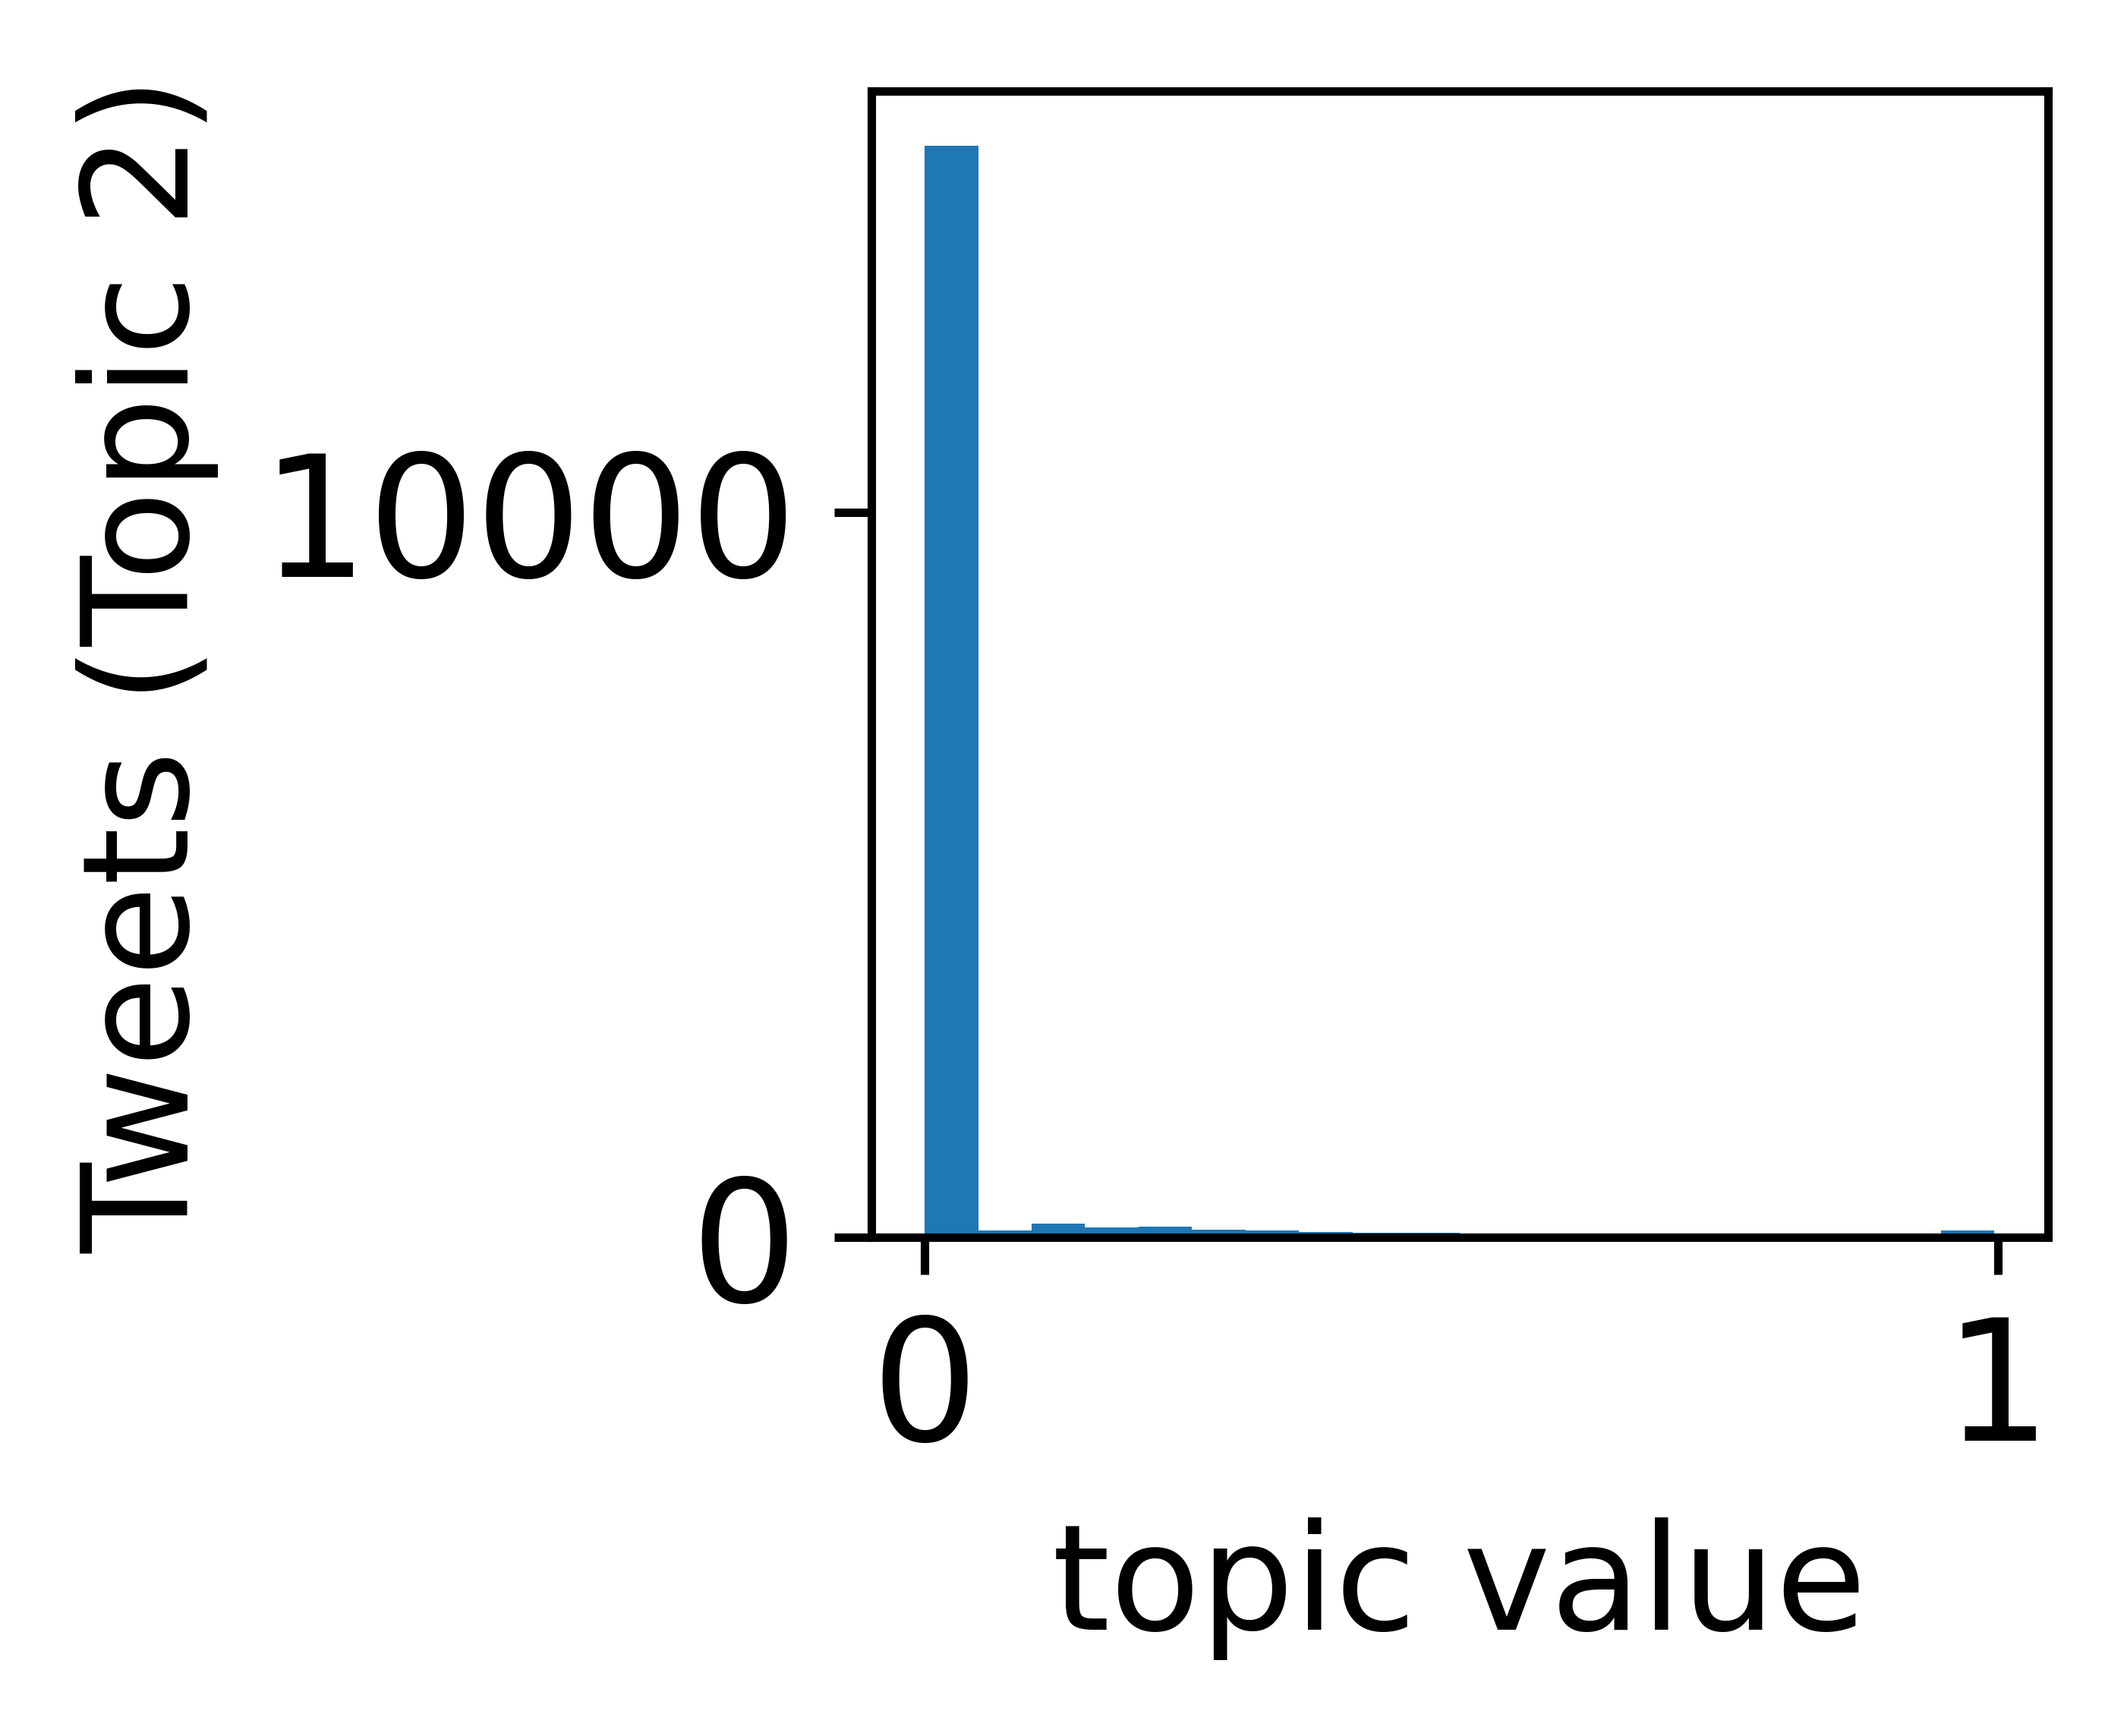

In [41]:
fig = plt.figure(figsize=(2,2), dpi=1000)
ax = plt.subplot(111)
plt.hist(kagDf.topic2,bins=20)

ax.tick_params(labelsize=16)
ax.set_xlabel('topic value',fontsize=14,fontweight='normal')
ax.set_ylabel('Tweets (Topic 2)',fontsize=14,fontweight='normal')
plt.show()
x = fig.tight_layout()

In [42]:
def makeWordCloud(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    sortedIdx = sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1)
    mySortedTweets = sortTweetsByIdx(cleanedTweetList,sortedIdx)
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()

In [40]:
makeWordCloud(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.2)


/tmp/ipykernel_52727/43916758.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  myCleanArray = np.array(cleanedTweetList)
/tmp/ipykernel_52727/43916758.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  myCleanArray = np.array(cleanedTweetList)
